# Import Required Libraries
Import necessary libraries such as pandas, numpy, librosa, sklearn, matplotlib, and pickle.

In [1]:
import pandas as pd
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pickle

# Load and Explore the Dataset
Load the 30-second and 3-second features datasets using pandas and display the first few rows to understand the structure.

In [2]:
# Load the dataset
df_30_sec = pd.read_csv('Data/features_30_sec.csv')
df_3_sec = pd.read_csv('Data/features_3_sec.csv')

# Display the shape and summary of the datasets
print(f"** df_30_sec has {df_30_sec.shape[0]} rows and {df_30_sec.shape[1]} columns **")
df_30_sec.describe()

print(f"** df_3_sec has {df_3_sec.shape[0]} rows and {df_3_sec.shape[1]} columns **")
df_30_sec.describe()

# Display the first few rows of the datasets
print("30-Second Features Dataset:")
print(df_30_sec.head())

print("\n3-Second Segments Dataset:")
print(df_3_sec.head())

** df_30_sec has 1000 rows and 60 columns **
** df_3_sec has 9990 rows and 60 columns **
30-Second Features Dataset:
          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mf

# Feature Extraction
Extract relevant audio features (e.g., MFCCs, spectral contrast, tempo) using librosa.

In [3]:
# Function to extract audio features from a file
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)

    # Length of the audio signal
    length = len(y)

    # Extract spectral and temporal features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_bandwidth_var = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    rolloff_var = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    zero_crossing_rate_var = np.var(librosa.feature.zero_crossing_rate(y))

    # Add chroma_stft features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    chroma_stft_var = np.var(chroma_stft)

    # Extract harmony and percussive features
    harmony = np.mean(librosa.effects.harmonic(y))
    harmony_var = np.var(librosa.effects.harmonic(y))
    perceptr = np.mean(librosa.effects.percussive(y))
    perceptr_var = np.var(librosa.effects.percussive(y))

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs, axis=1)  # Compute mean for each MFCC
    mfccs_var = np.var(mfccs, axis=1)  # Compute variance for each MFCC

    # Extract RMS
    rms = np.mean(librosa.feature.rms(y=y))
    rms_var = np.var(librosa.feature.rms(y=y))

    # Extract tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Combine features
    features = np.hstack(
        [
            length,
            chroma_stft_mean,
            chroma_stft_var,
            rms,
            rms_var,
            spectral_centroid,
            spectral_centroid_var,
            spectral_bandwidth,
            spectral_bandwidth_var,
            rolloff,
            rolloff_var,
            zero_crossing_rate,
            zero_crossing_rate_var,
            harmony,
            harmony_var,
            perceptr,
            perceptr_var,
            tempo,
            mfccs_mean,  # Add MFCC means
            mfccs_var,  # Add MFCC variances
        ]
    )

    # Check feature count
    print("Extracted features count:", len(features))  # Should be 58
    return features


# Example usage of the feature extraction function
# Assuming 'example_audio.wav' is an audio file in the current directory
example_features = extract_features("Data/genres_original/blues/blues.00000.wav")
print("Extracted Features:", example_features)

Extracted features count: 58
Extracted Features: [ 6.61500000e+05  3.49950522e-01  8.87521580e-02  1.30191997e-01
  2.83037149e-03  1.78441655e+03  1.29739837e+05  2.00265711e+03
  8.58293459e+04  3.80641865e+03  9.01329660e+05  8.30663911e-02
  7.66734295e-04 -4.52644199e-05  8.17182474e-03  6.84197676e-06
  5.70428092e-03  1.23046875e+02 -1.13619385e+02  1.21553032e+02
 -1.91510563e+01  4.23457680e+01 -6.37116766e+00  1.86130333e+01
 -1.36920605e+01  1.53393784e+01 -1.22836170e+01  1.09737759e+01
 -8.32240963e+00  8.80678749e+00 -3.66580200e+00  5.74593878e+00
 -5.16171122e+00  7.50297844e-01 -1.68835795e+00 -4.09328490e-01
 -2.29886913e+00  1.21994710e+00  2.57081274e+03  2.95724396e+02
  2.35579819e+02  1.50835358e+02  1.68024643e+02  8.91695862e+01
  6.76047897e+01  6.90630722e+01  8.21525040e+01  6.34004707e+01
  6.18105354e+01  5.12919998e+01  4.12516289e+01  4.05609818e+01
  4.98234978e+01  5.24641380e+01  3.65646057e+01  4.16436272e+01
  5.50766869e+01  4.69756355e+01]


# Train-Test Split
Split the dataset into training and testing sets using train_test_split from sklearn.

In [4]:
# Define the features (X) and labels (y) for the 30-second features dataset
X_30_sec = df_30_sec.drop(columns=["filename", "label"])
y_30_sec = df_30_sec["label"]

# Define the features (X) and labels (y) for the 3-second segments dataset
X_3_sec = df_3_sec.drop(columns=["filename", "label"])
y_3_sec = df_3_sec["label"]

feature_names = X_30_sec.columns.tolist()

# Split the 30-second features dataset into training and testing sets
X_train_30_sec, X_test_30_sec, y_train_30_sec, y_test_30_sec = train_test_split(
    X_30_sec, y_30_sec, test_size=0.2, random_state=42
)

# Split the 3-second segments dataset into training and testing sets
X_train_3_sec, X_test_3_sec, y_train_3_sec, y_test_3_sec = train_test_split(
    X_3_sec, y_3_sec, test_size=0.2, random_state=42
)

# Display the shapes of the resulting datasets
print("30-Second Features Dataset:")
print("Training set shape:", X_train_30_sec.shape, y_train_30_sec.shape)
print("Testing set shape:", X_test_30_sec.shape, y_test_30_sec.shape)

print("\n3-Second Segments Dataset:")
print("Training set shape:", X_train_3_sec.shape, y_train_3_sec.shape)
print("Testing set shape:", X_test_3_sec.shape, y_test_3_sec.shape)

30-Second Features Dataset:
Training set shape: (800, 58) (800,)
Testing set shape: (200, 58) (200,)

3-Second Segments Dataset:
Training set shape: (7992, 58) (7992,)
Testing set shape: (1998, 58) (1998,)


# Train the Random Forest Classifier
Train a Random Forest Classifier on the training data. Random forests are less prone to overfitting due to their ensemble nature

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Encode the target labels
label_encoder = LabelEncoder()
y_train_30_sec_encoded = label_encoder.fit_transform(y_train_30_sec)
y_test_30_sec_encoded = label_encoder.transform(y_test_30_sec)

# Initialize the Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
)

# Train the classifier on the 30-second features dataset
rf_classifier.fit(X_train_30_sec, y_train_30_sec_encoded)

# Predict on the test set
y_pred_30_sec = rf_classifier.predict(X_test_30_sec)

# Decode the predicted labels back to original
y_pred_30_sec_decoded = label_encoder.inverse_transform(y_pred_30_sec)

# Evaluate the model using original labels
accuracy_30_sec = accuracy_score(y_test_30_sec, y_pred_30_sec_decoded)
classification_report_30_sec = classification_report(
    y_test_30_sec, y_pred_30_sec_decoded
)

print("30-Second Features Dataset:")
print("Accuracy:", accuracy_30_sec)
print("Classification Report:\n", classification_report_30_sec)

# Encode the target labels for the 3-second segments dataset
y_train_3_sec_encoded = label_encoder.fit_transform(y_train_3_sec)
y_test_3_sec_encoded = label_encoder.transform(y_test_3_sec)

# Train the classifier on the 3-second segments dataset
rf_classifier.fit(X_train_3_sec, y_train_3_sec_encoded)

# Predict on the test set
y_pred_3_sec = rf_classifier.predict(X_test_3_sec)

# Decode the predicted labels back to original
y_pred_3_sec_decoded = label_encoder.inverse_transform(y_pred_3_sec)

# Evaluate the model using original labels
accuracy_3_sec = accuracy_score(y_test_3_sec, y_pred_3_sec_decoded)
classification_report_3_sec = classification_report(y_test_3_sec, y_pred_3_sec_decoded)

print("\n3-Second Segments Dataset:")
print("Accuracy:", accuracy_3_sec)
print("Classification Report:\n", classification_report_3_sec)

30-Second Features Dataset:
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

       blues       0.70      0.70      0.70        20
   classical       1.00      1.00      1.00        13
     country       0.89      0.63      0.74        27
       disco       0.80      0.76      0.78        21
      hiphop       0.62      0.87      0.72        15
        jazz       0.88      0.95      0.91        22
       metal       0.89      0.96      0.92        25
         pop       0.77      0.77      0.77        13
      reggae       0.74      0.61      0.67        23
        rock       0.58      0.67      0.62        21

    accuracy                           0.78       200
   macro avg       0.79      0.79      0.78       200
weighted avg       0.79      0.78      0.78       200


3-Second Segments Dataset:
Accuracy: 0.8753753753753754
Classification Report:
               precision    recall  f1-score   support

       blues       0.86      0.86     

# Evaluate the Model
Random forests are less prone to overfitting due to their ensemble nature
They provide insights into which features are most important for classification

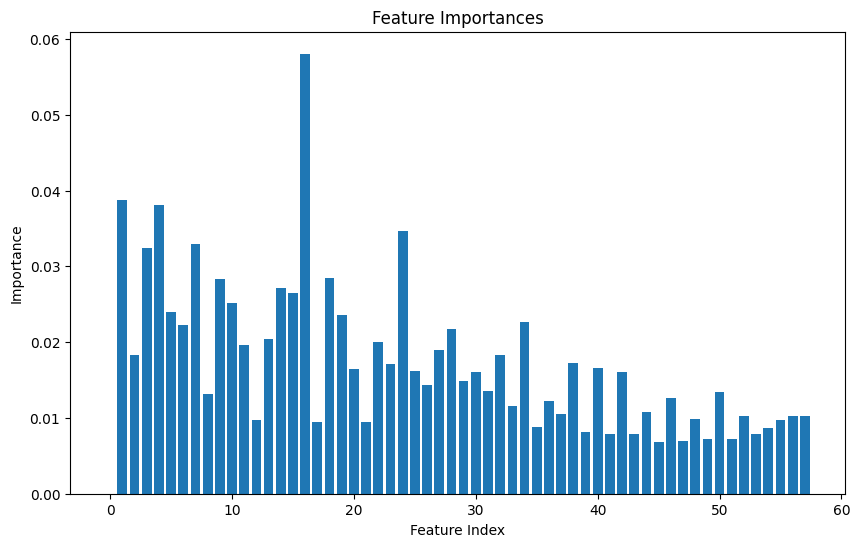

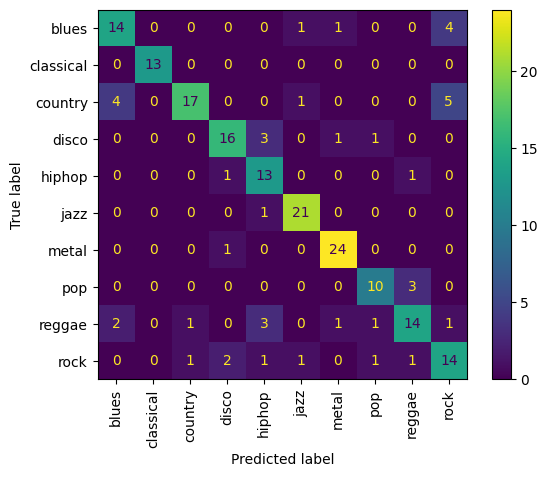

In [6]:
import matplotlib.pyplot as plt

# Feature importance
feature_importances = rf_classifier.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_test_30_sec, y_pred_30_sec_decoded, labels=label_encoder.classes_
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.show()

# Improve the Model


In [ ]:

#import matplotlib.pyplot as plt

# Check the class distribution
#label_counts = y_train_30_sec.value_counts()

# Plot the distribution
# label_counts.plot(kind="bar")
# plt.title("Class Distribution in Training Data")
# plt.xlabel("Genre")
# plt.ylabel("Number of Samples")
# plt.show()

# import seaborn as sns

# for feature in X_train_30_sec.columns[:5]:  # Adjust for more features
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=y_train_30_sec, y=X_train_30_sec[feature])
#     plt.title(f"Feature: {feature}")
#     plt.xticks(rotation=45)
#     plt.show()

# Save the Model
Serialize the trained model using pickle for later use in the web app.

In [ ]:
# Serialize the trained model using pickle for later use in the web app
model_filename = "random_forest_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump((rf_classifier, feature_names), file)

print(f"Model saved to {model_filename}")

Model saved to random_forest_model.pkl


# Build and Run the Web App with Flask
Create a Flask web app to handle file uploads, extract features, make predictions, and display results.

In [9]:
from flask import Flask, request, jsonify, render_template
import librosa
import numpy as np
import pickle


# Initialize the Flask app
app = Flask(__name__)

genre_mapping = {
    0: "classical",
    1: "jazz",
    2: "country",
    3: "pop",
    4: "rock",
    5: "hiphop",
    6: "metal",
    7: "blues",
    8: "reggae",
    9: "disco",
}

# Load the trained model
model_filename = "random_forest_model.pkl"
with open(model_filename, "rb") as file:
    model, feature_names = pickle.load(file)


# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)

    # Length of the audio signal
    length = len(y)

    # Extract spectral and temporal features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_bandwidth_var = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    rolloff_var = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    zero_crossing_rate_var = np.var(librosa.feature.zero_crossing_rate(y))

    # Add chroma_stft features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    chroma_stft_var = np.var(chroma_stft)

    # Extract harmony and percussive features
    harmony = np.mean(librosa.effects.harmonic(y))
    harmony_var = np.var(librosa.effects.harmonic(y))
    perceptr = np.mean(librosa.effects.percussive(y))
    perceptr_var = np.var(librosa.effects.percussive(y))

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs, axis=1)  # Compute mean for each MFCC
    mfccs_var = np.var(mfccs, axis=1)  # Compute variance for each MFCC

    # Extract RMS
    rms = np.mean(librosa.feature.rms(y=y))
    rms_var = np.var(librosa.feature.rms(y=y))

    # Extract tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Combine features
    features = np.hstack(
        [
            length,
            chroma_stft_mean,
            chroma_stft_var,
            rms,
            rms_var,
            spectral_centroid,
            spectral_centroid_var,
            spectral_bandwidth,
            spectral_bandwidth_var,
            rolloff,
            rolloff_var,
            zero_crossing_rate,
            zero_crossing_rate_var,
            harmony,
            harmony_var,
            perceptr,
            perceptr_var,
            tempo,
            mfccs_mean,
            mfccs_var,
        ]
    )

    # Check feature count
    print("Extracted features count:", len(features))
    return features


# Route for the home page
@app.route("/")
def home():
    return render_template("index.html")


# Route for handling file uploads and making predictions
@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    file = request.files["file"]
    if file.filename == "":
        return jsonify({"error": "No file selected"}), 400

    # Save the uploaded file temporarily
    file_path = "temp_audio.wav"
    file.save(file_path)

    # Extract features and make prediction
    features = extract_features(file_path)
    features_df = pd.DataFrame([features], columns=feature_names)  # Use feature names
    prediction = model.predict(features_df)
    # features = features.reshape(1, -1)  # Reshape for the model
    # prediction = model.predict(features)

    # Convert prediction to native Python type and map to genre name
    genre_label = int(prediction[0])
    genre_name = genre_mapping.get(genre_label, "Unknown")

    # Return the prediction result
    return jsonify({"genre": genre_name})


# Run the app
if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Nov/2024 19:56:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Nov/2024 19:56:29] "POST /predict HTTP/1.1" 200 -


Extracted features count: 58
